In [1]:
# LSTM Autoencoder를 이용한 이상 온도 탐지
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from myProcessData import myProcessData

# 데이터 준비
# temperature.csv 파일에서 데이터 불러오기
all_data = []
data = pd.read_csv('csv/pjh_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/pjh_temperature2.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/jdk_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/bsb_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)


# # 데이터 전처리 -----------------------------------------------
sequence_length = 40  # 시퀀스 길이 설정
# train_dataset, train_dataloader, test_subset_dataset = myProcessData(all_data[0], sequence_length)

In [2]:
# 모델 정의 및 학습 --------------------------------------
# 모델 구성
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        encoded_output, _ = self.encoder(x)
        decoded_output, _ = self.decoder(encoded_output)
        return decoded_output

# 모델 생성
hidden_size = 16  # LSTM 레이어의 히든 상태 크기
num_layers = 2  # LSTM 레이어의 개수
input_size = 1  # 입력 데이터의 차원
model = LSTM_Autoencoder(input_size, hidden_size, num_layers)

# 손실 함수 정의
loss_function = nn.MSELoss()

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 차원 2차원으로 변경
# train_data = np.reshape(train_data, (-1, sequence_length, input_size))
# test_data = np.reshape(test_data, (-1, sequence_length, input_size))

# K-fold Cross Validation
k = 4  # Number of folds
fold_losses = []
test_losses = []  # List to store the test losses
result_fold_loss = []

# K-fold data splitting
# fold_size = len(train_data) // k



In [3]:
for i in range(k):
    print(f"Fold {i+1}")
    # Split train data into train and validation sets
    
    fold_data = all_data[i]
    mean = np.mean(fold_data)
    std = np.std(fold_data)
    fold_data = (fold_data - mean) / std

    # 데이터를 시계열 시퀀스로 변환
    sequences = []
    for index in range(len(fold_data) - sequence_length + 1):
        sequence = fold_data[index:index+sequence_length]
        sequences.append(sequence)

    print(len(sequences))

    # 학습 데이터와 테스트 데이터 분리
    train_ratio = 0.8  # 학습 데이터 비율
    train_size = int(len(sequences) * train_ratio)
    train_data = sequences[:train_size]
    test_data = sequences[train_size:]

    # 데이터를 넘파이 배열로 변환
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    input_size = 1  # 입력 데이터의 차원
    # 차원 3차원으로 변경
    train_data = np.reshape(train_data, (-1, input_size, sequence_length))
    test_data = np.reshape(test_data, (-1, input_size, sequence_length))

    # PyTorch 데이터셋 및 데이터로더 생성
    train_data = np.transpose(train_data,(0,2,1))
    train_subset_dataset = torch.Tensor(train_data)
    train_subset_dataloader = torch.utils.data.DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
    test_data = np.transpose(test_data,(0,2,1))
    test_subset_dataset = torch.Tensor(test_data)
    
    # 모델 초기화
    model = LSTM_Autoencoder(input_size, hidden_size, num_layers)
    # 옵티마이저 설정
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    fold_loss=[]
    # 학습
    num_epochs = 50  # 학습 횟수 설정
    for epoch in range(num_epochs):
        print(epoch)
        for data in train_subset_dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_function(outputs.reshape(-1, input_size), data.reshape(-1, input_size))
            loss.backward()
            optimizer.step()
        fold_loss.append(loss.item())

    # 테스트 데이터에 대한 재구성 오차 계산
    # test_subset_dataset = torch.Tensor(test_data)
    with torch.no_grad():
        test_subset_outputs = model(test_subset_dataset)
        test_subset_loss = loss_function(test_subset_outputs, test_subset_dataset)

    # Append the average test loss to test_losses list
    print(f"Test loss: {test_subset_loss.item()}")
    print('===========================================================')
    # 수정. 학습결과인 MSE를 기록한다.
    fold_losses.append(fold_loss)
    # 각 fold 별 최종 학습 결과인 MSE를 기록
    result_fold_loss.append(fold_loss[-1])

    # 이건 미리 나눴던 테스트 데이터들을 이용해 예측한 결과인 MSE
    test_losses.append(test_subset_loss.item())

Fold 1
461
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Test loss: 0.16851188242435455
Fold 2
461
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Test loss: 1.1185767650604248
Fold 3
461
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Test loss: 0.8709516525268555
Fold 4
461
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Test loss: 0.3154626190662384


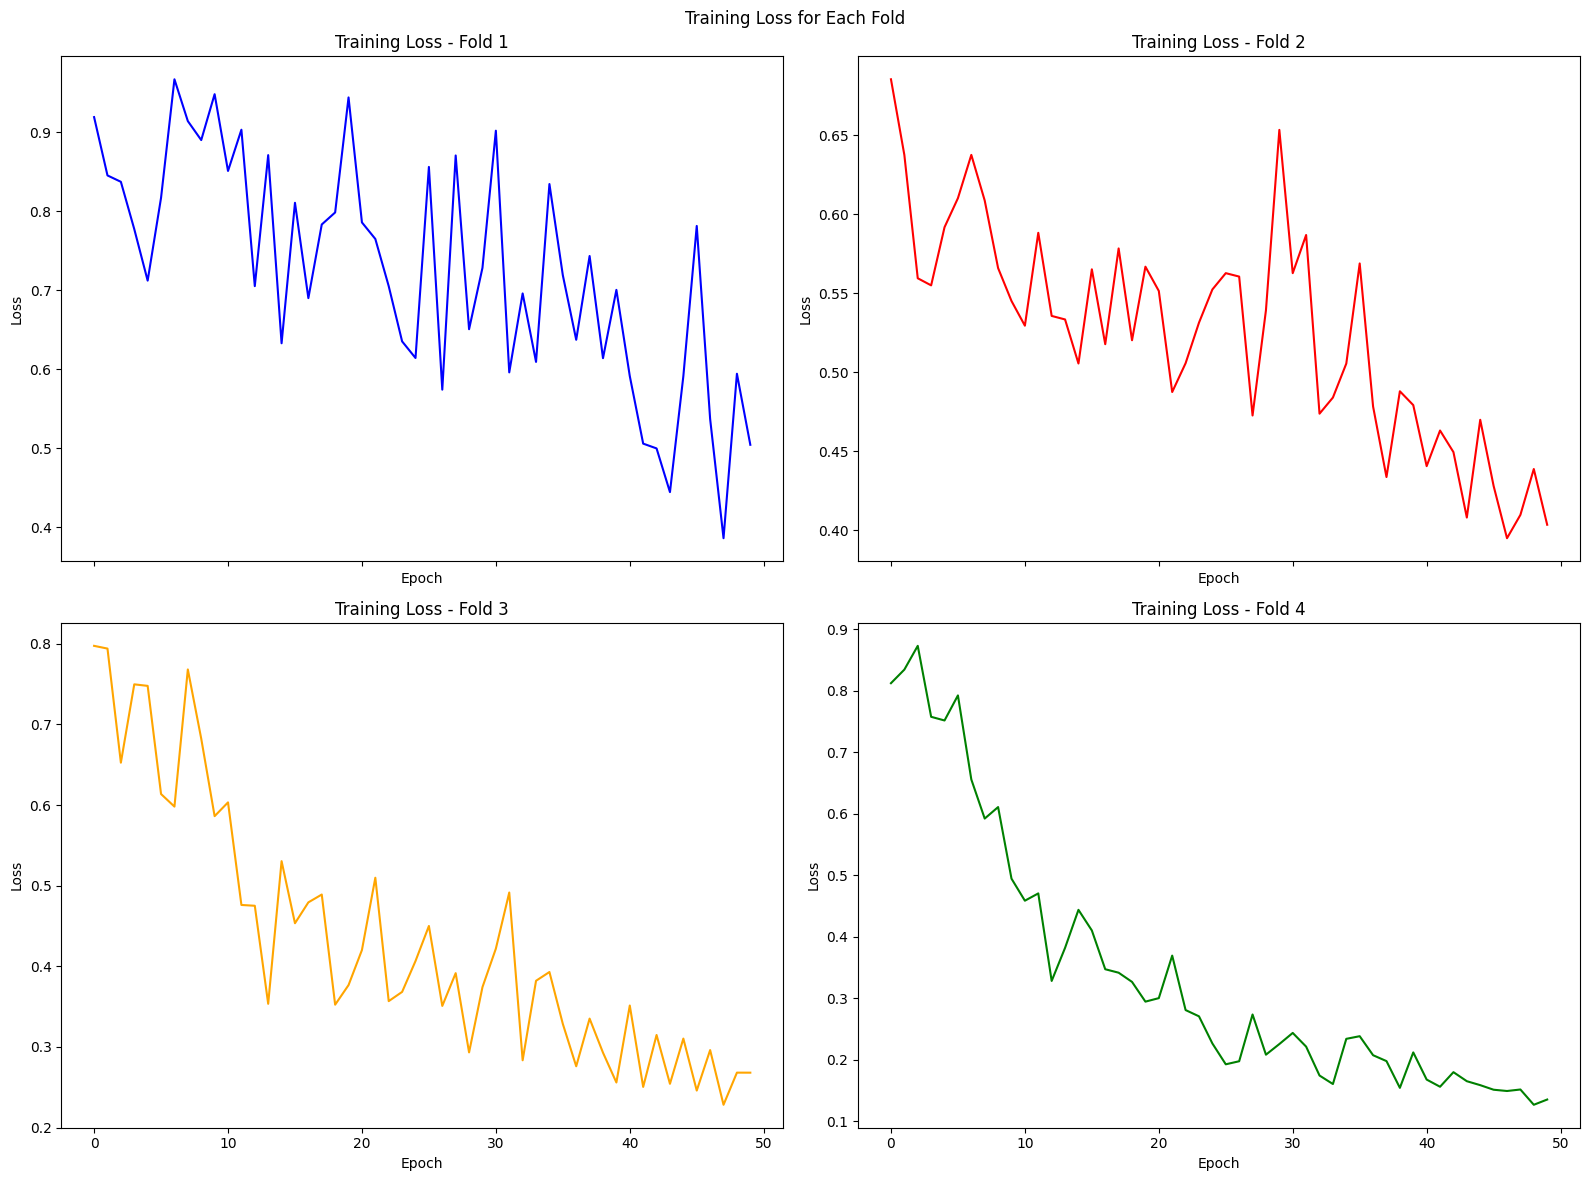

In [4]:
# # 최소값과 인접한 값을 클러스터링
# # K-means 알고리즘 적용
# data = np.array(result_fold_loss).reshape(-1, 1)
# k = 2  # 클러스터 개수
# kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
# kmeans.fit(data)

# # 클러스터링 결과 확인
# labels = kmeans.labels_
# min_value = np.min(result_fold_loss)
# min_label = labels[data.flatten() == min_value]
# cluster_data = data[labels == min_label]


# # Calculate the mean threshold
# mean_threshold = np.mean(cluster_data)
# print(f"Mean threshold: {mean_threshold:.4f}")

# # 이상 감지
# anomaly_indices = torch.where(test_subset_loss > mean_threshold)[0]
# anomaly_data = test_data[anomaly_indices]

# # 이상 감지 결과 출력
# print(f'Anomaly data indices: {anomaly_indices.tolist()}')
# anomaly_data = (anomaly_data * std) + mean
# print(f"Anomaly data: {anomaly_data}")

# Plotting the losses for each fold
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

axes[0, 0].plot(range(len(fold_losses[0])), fold_losses[0], 'b', label="Fold 1")
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss - Fold 1')

axes[0, 1].plot(range(len(fold_losses[1])), fold_losses[1], 'r', label="Fold 2")
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training Loss - Fold 2')

axes[1, 0].plot(range(len(fold_losses[2])), fold_losses[2], 'orange', label="Fold 3")
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss - Fold 3')

axes[1, 1].plot(range(len(fold_losses[3])), fold_losses[3], 'g', label="Fold 4")
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training Loss - Fold 4')


plt.suptitle('Training Loss for Each Fold')
plt.tight_layout()
plt.show()

# # 테스트 데이터 - 손실값 
# print(test_data)
# print(test_losses)
# plt.figure(figsize=(10, 6))
# # for i, test_loss in enumerate(test_losses):
# #     plt.plot(range(len(test_loss)), test_loss, label="Test")
# plt.bar(range(len(test_losses)), test_losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.grid(True)
# plt.show()